In [1]:
import pypsa
import numpy as np
import math
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import geopandas as gpd
from shapely.errors import ShapelyDeprecationWarning
from pypsa.clustering.spatial import (
    aggregategenerators,
    aggregateoneport,
    busmap_by_stubs,
    get_clustering_from_busmap,
)
from matching.games import HospitalResident
from geopy.distance import geodesic
from shapely import Point
import operator
import spatial
import logging
# warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
# plt.rc("figure", figsize=(10, 8))

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [2]:
# construct preferences
def get_preferences(network1, network2, gdf1, gdf2, reverse=False):
    network1_preferences = dict()
    for bus1 in network1.buses.index:
        bus1_preferences = dict()
        for bus2 in network2.buses.index:
            if reverse == True:
                dist = distance_between_buses(gdf1, gdf2, bus2, bus1)
            else:
                dist = distance_between_buses(gdf1, gdf2, bus1, bus2)
            # if bus1 and bus2 are further away than threshold value, then they should
            # never be merged
            bus1_preferences[bus2] = dist
        bus1_preferences = sorted(bus1_preferences, key=lambda x: x[1])
        network1_preferences[bus1] = bus1_preferences

    return network1_preferences


def distance_between_buses(gdf1, gdf2, bus_from_network_1, bus_from_network_2):
    bus1_point = gdf1.loc[bus_from_network_1, "geometry"]
    bus2_point = gdf2.loc[bus_from_network_2, "geometry"]
    distance = bus1_point.distance(bus2_point)
    return distance


def update_component_name(network, component_name, new_value, old_value):
    # update name in static dataframe for this component
    network.df(component_name).rename(index={old_value: new_value}, inplace=True)

    list_name = component_name.lower()
    # update name in static dataframes of other components
    for component in network.iterate_components():
        if list_name in list(component.df.keys()):
            component.df.get(list_name).replace({old_value: new_value}, inplace=True)

    # update name in time-varying dataframes of this component (if any exist)
    if network.pnl(component_name):
        for k, v in network.pnl(component_name).items():
            network.pnl(component_name).get(k).rename(
                columns={old_value: new_value}, inplace=True
            )

    # special case where a bus name is changed - requires special treatment
    if component_name == "Bus":
        for component in network.iterate_components():
            if "bus" in list(component.df.keys()):
                component.df.get("bus").replace({old_value: new_value}, inplace=True)
            if "bus0" in list(component.df.keys()):
                component.df.get("bus0").replace({old_value: new_value}, inplace=True)
            if "bus1" in list(component.df):
                component.df.get("bus1").replace({old_value: new_value}, inplace=True)


def merge(network, other):
    to_skip = ["Network"]
    if other.srid != network.srid:
        print(
            f"Warning: spatial Reference System Indentifier {other.srid} for new network not equal to value {network.srid} of existing network. Original value will be used."
        )
    snapshots_aligned = network.snapshots.equals(other.snapshots)
    weightings_aligned = network.snapshot_weightings.equals(other.snapshot_weightings)
    assert (
        snapshots_aligned and weightings_aligned
    ), "Error, snapshots or snapshot weightings do not agree, cannot add network with time-varying attributes."

    new_network = network
    for component in other.iterate_components(other.components.keys() - to_skip):
        # we do not add components whose ID is present in this network
        index_list = list(
            set(component.df.index) - set(network.df(component.name).index)
        )
        if set(index_list) != set(component.df.index) and component.name not in [
            "LineType",
            "TransformerType",
        ]:
            print(
                f"Warning: components of type {component.name} in new network have duplicate IDs in existing network. These components will not be added"
            )
        # import static data for component
        df_to_add = component.df[component.df.index.isin(index_list)]
        new_network.import_components_from_dataframe(df_to_add, component.name)
        # import time series data for component
        for attr, df in component.pnl.items():
            df_to_add = df.loc[:, df.columns.isin(index_list)]
            new_network.import_series_from_dataframe(df, component.name, attr)

        return new_network


# rename any component in network1 such that there is a component (of the same type) in network2 with the same name
def rename_duplicated_items(network1, network2):
    for component in network1.iterate_components():
        n1_component_index = component.df.index
        n2_component_index = network2.df(component.name).index
        for comp1 in n1_component_index:
            for comp2 in n2_component_index:
                if comp1 == comp2:
                    update_component_name(network1, component.name, comp1 + "_n1", comp1)
                    continue

In [3]:
n1 = pypsa.Network("elec_s_37.nc")
n2 = pypsa.Network("elec_s_110_ec.nc")

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/gbotemi/m

In [6]:

print("rename duplicated items")
rename_duplicated_items(n1, n2)

/var/folders/c3/657p__892k72qxh6r8fdkqsh0000gn/T/ipykernel_4746/557624778.py:35: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/c3/657p__892k72qxh6r8fdkqsh0000gn/T/ipykernel_4746/557624778.py:35: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

rename duplicated items


In [9]:
gdf1 = gpd.GeoDataFrame(n1.buses, geometry=gpd.points_from_xy(
    n1.buses.x, n1.buses.y), crs="EPSG:4326").to_crs("EPSG:3857")
gdf2 = gpd.GeoDataFrame(n2.buses, geometry=gpd.points_from_xy(
    n2.buses.x, n2.buses.y), crs="EPSG:4326").to_crs("EPSG:3857")

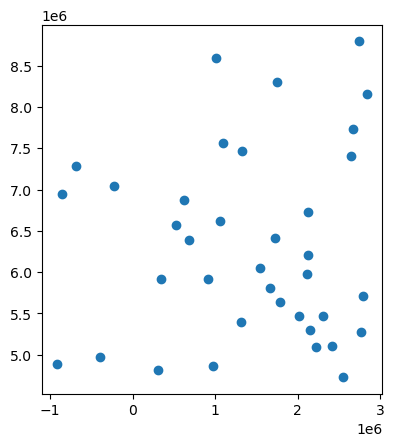

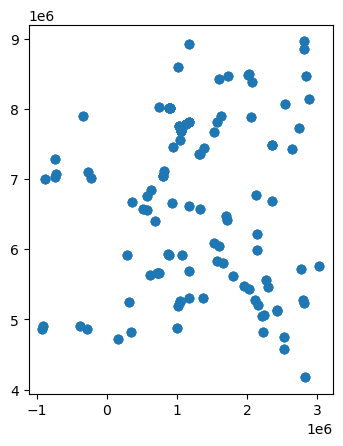

In [10]:
gdf1.plot(), gdf2.plot()
plt.show()

In [11]:
print("n1 has order "+str(n1.buses.size))
print("n2 has order "+str(n2.buses.size))

n1 has order 481
n2 has order 4290


In [12]:
n1_preferences = get_preferences(n1, n2, gdf1, gdf2)
n2_preferences = get_preferences(n2, n1, gdf1, gdf2, reverse=True)
capacities = {bus: 1 for bus in n2.buses.index} # what is going on here??

# could update prefs to remove partners further than thres distance
stable_marriage_instance = HospitalResident.create_from_dictionaries(
    n1_preferences, n2_preferences, capacities)
# busmap has keys from n2 and values from n1
print("get the busmap")
busmap = stable_marriage_instance.solve()

get the busmap


In [13]:
string_busmap = dict()
for key in busmap.keys():
    value = busmap[key]
    string_busmap[str(key)] = str(value)

In [15]:
print("merging the original networks")

n3 = merge(n2, n1)


Index(['AL0 0 offwind-ac', 'AL0 0 oil_n1', 'AL0 0 onwind_n1', 'AL0 0 ror_n1',
       'AL0 0 solar_n1', 'AT0 0 CCGT_n1', 'AT0 0 OCGT', 'AT0 0 coal_n1',
       'AT0 0 onwind_n1', 'AT0 0 ror_n1',
       ...
       'SI0 0 ror_n1', 'SI0 0 solar_n1', 'SK0 0 CCGT_n1', 'SK0 0 OCGT',
       'SK0 0 coal_n1', 'SK0 0 lignite_n1', 'SK0 0 nuclear_n1',
       'SK0 0 onwind_n1', 'SK0 0 ror_n1', 'SK0 0 solar_n1'],
      dtype='object', name='Generator', length=284)


merging the original networks


In [16]:
for bus in n3.buses.index:
    b = str(bus)
    if b not in string_busmap.keys():
        if bus not in n1.buses.index and bus not in n2.buses.index:
            string_busmap[b] = b

(<matplotlib.collections.PatchCollection at 0x16b378850>,
 <matplotlib.collections.LineCollection at 0x16dfad3f0>)

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



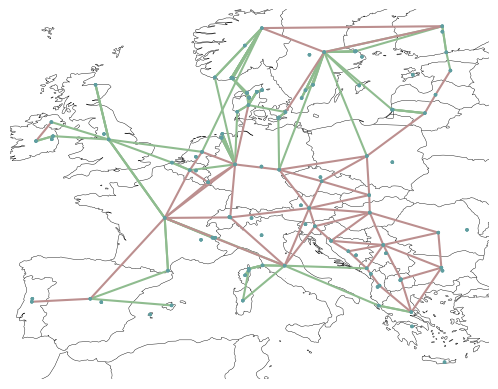

In [17]:
n3.plot()

In [18]:
n3.buses = n3.buses.drop("country",axis=1)
n3.buses = n3.buses.drop("carrier",axis=1)

In [19]:
n3.buses

,v_nom,x,y,control,generator,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,
AL0 0,380.0,20.081992,41.314335,Slack,AL0 0 coal,,,1.0,0.0,inf,
AL58 0,220.0,19.924780,41.205880,Slack,AL58 0 onwind,,,1.0,0.0,inf,
AT0 0,380.0,14.351116,47.617484,PQ,,,,1.0,0.0,inf,
AT60 0,300.0,13.685700,47.850300,Slack,AT60 0 onwind,,,1.0,0.0,inf,
BA0 0,380.0,17.548392,44.107052,PQ,,,,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...
SE71 0 battery,1.0,14.667900,57.664200,PQ,,,,1.0,0.0,inf,
SE74 0 battery,1.0,14.055800,57.223200,PQ,,,,1.0,0.0,inf,
SI0 0 battery,1.0,14.823035,46.145025,PQ,,,,1.0,0.0,inf,


In [20]:
print("now create the clustering")
clustering = get_clustering_from_busmap(n3, string_busmap, with_time=False)

n4 = clustering.network
n4.buses.loc[:, ["x", "y"]] = n2.buses.loc[n3.buses.index, ["x", "y"]]

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/pypsa/clustering/spatial.py:314: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/gbotemi/miniconda3/envs/network-comparison/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of 

now create the clustering
